In [1]:
%matplotlib inline

import sys
sys.path.append('../sarcube')
from sarcube import *
dc= sarcube()

In [21]:
try:
    from hdstats import nangeomedian_pcm as gm
except:
    #module use /g/data/v10/public/modules/modulefiles
    #module load pcm
    from pcm import gmpcm as gm
 


In [26]:
import dask

def reshape_for_geomedian(ds, axis='time'):
    dims = set(v.dims for v in ds.data_vars.values())
    if len(dims) != 1:
        raise ValueError("All bands should have same dimensions")

    dims = dims.pop()
    if len(dims) != 3:
        raise ValueError("Expect 3 dimensions on input")

    if axis not in dims:
        raise ValueError(f"No such axis: {axis}")

    dims = tuple(d for d in dims if d != axis) + ('band', axis)

    nodata = set(getattr(v, 'nodata', None) for v in ds.data_vars.values())
    if len(nodata) == 1:
        nodata = nodata.pop()
    else:
        nodata = None

    # xx: {y, x}, band, time
    xx = ds.to_array(dim='band').transpose(*dims)

    if nodata is not None:
        xx.attrs.update(nodata=nodata)

    return xx

def xr_geomedian(ds, axis='time', where=None, **kwargs):
    """

    :param ds: xr.Dataset|xr.DataArray|numpy array

    Other parameters:
    **kwargs -- passed on to pcm.gnmpcm
       maxiters   : int         1000
       eps        : float       0.0001
       num_threads: int| None   None
    """

    def norm_input(ds, axis):
        if isinstance(ds, xr.DataArray):
            xx = ds
            if len(xx.dims) != 4:
                raise ValueError("Expect 4 dimensions on input: y,x,band,time")
            if axis is not None and xx.dims[3] != axis:
                raise ValueError(f"Can only reduce last dimension, expect: y,x,band,{axis}")
            return None, xx, xx.data
        elif isinstance(ds, xr.Dataset):
            xx = reshape_for_geomedian(ds, axis)
            return ds, xx, xx.data
        else:  # assume numpy or similar
            xx_data = ds
            if xx_data.ndim != 4:
                raise ValueError("Expect 4 dimensions on input: y,x,band,time")
            return None, None, xx_data

    ds, xx, xx_data = norm_input(ds, axis)
    is_dask = dask.is_dask_collection(xx_data)

    if where is not None:
        if is_dask:
            raise NotImplementedError("Dask version doesn't support output masking currently")

        if where.shape != xx_data.shape[:2]:
            raise ValueError("Shape for `where` parameter doesn't match")
        set_nan = ~where
    else:
        set_nan = None

    if is_dask:
        if xx_data.shape[-2:] != xx_data.chunksize[-2:]:
            xx_data = xx_data.rechunk(xx_data.chunksize[:2] + (-1, -1))

        data = dask.array.map_blocks(lambda x: gm(x, **kwargs),
                             xx_data,
                             name='geomedian',
                             dtype=xx_data.dtype,
                             drop_axis=3)
    else:
        data = gm(xx_data, **kwargs)

    if set_nan is not None:
        data[set_nan, :] = np.nan

    if xx is None:
        return data

    dims = xx.dims[:-1]
    cc = {k: xx.coords[k] for k in dims}
    xx_out = xr.DataArray(data, dims=dims, coords=cc)

    if ds is None:
    #    xx_out.attrs.update(xx.attrs)
        return xx_out

    ds_out = xx_out.to_dataset(dim='band')
    for b in ds.data_vars.keys():
        src, dst = ds[b], ds_out[b]
        #dst.attrs.update(src.attrs)

    return ds_out


In [3]:
x0=1340000
y0=-4030000
x = (x0-1000, x0+1000)
y = (y0-1000, y0+1000)

In [75]:
year = '2018'
bands = ['vv','vh']
data = dc.load(product ='s1_gamma0_scene', speckle_filter='lee', db=False, 
                   group_by = 'solar_day', measurements=bands,  
                   #resampling='bilinear', #dask_chunks={'time': -1, 'x':1000, 'y': 1000},
                   resolution=(-25, 25), crs = 'EPSG:3577',
                   x = x, y = y, time = ('%s-01-01'%year, '%s-12-31'%year),
                   )

data = data.where(data.vh>0.001)

In [76]:
s1_gm_nearest= xr_geomedian(data[bands])

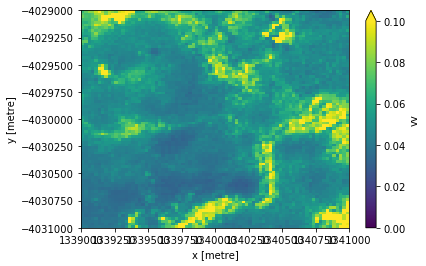

In [79]:
s1_gm_nearest.vv.plot.imshow(vmin=0,vmax=0.1);

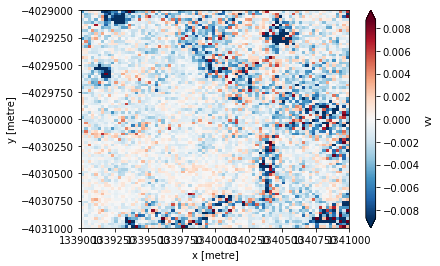

In [77]:
(s1_gm_nearest.vv-s1_gm.vv).plot.imshow(robust=True);

In [66]:
s1_gm = xr_geomedian(data[bands])

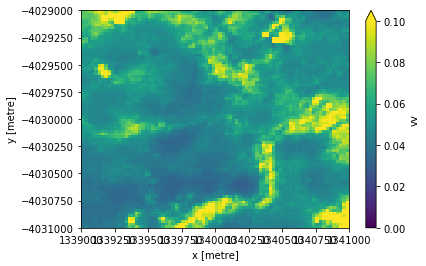

In [67]:
s1_gm.vv.plot.imshow(vmin=0,vmax=0.1);

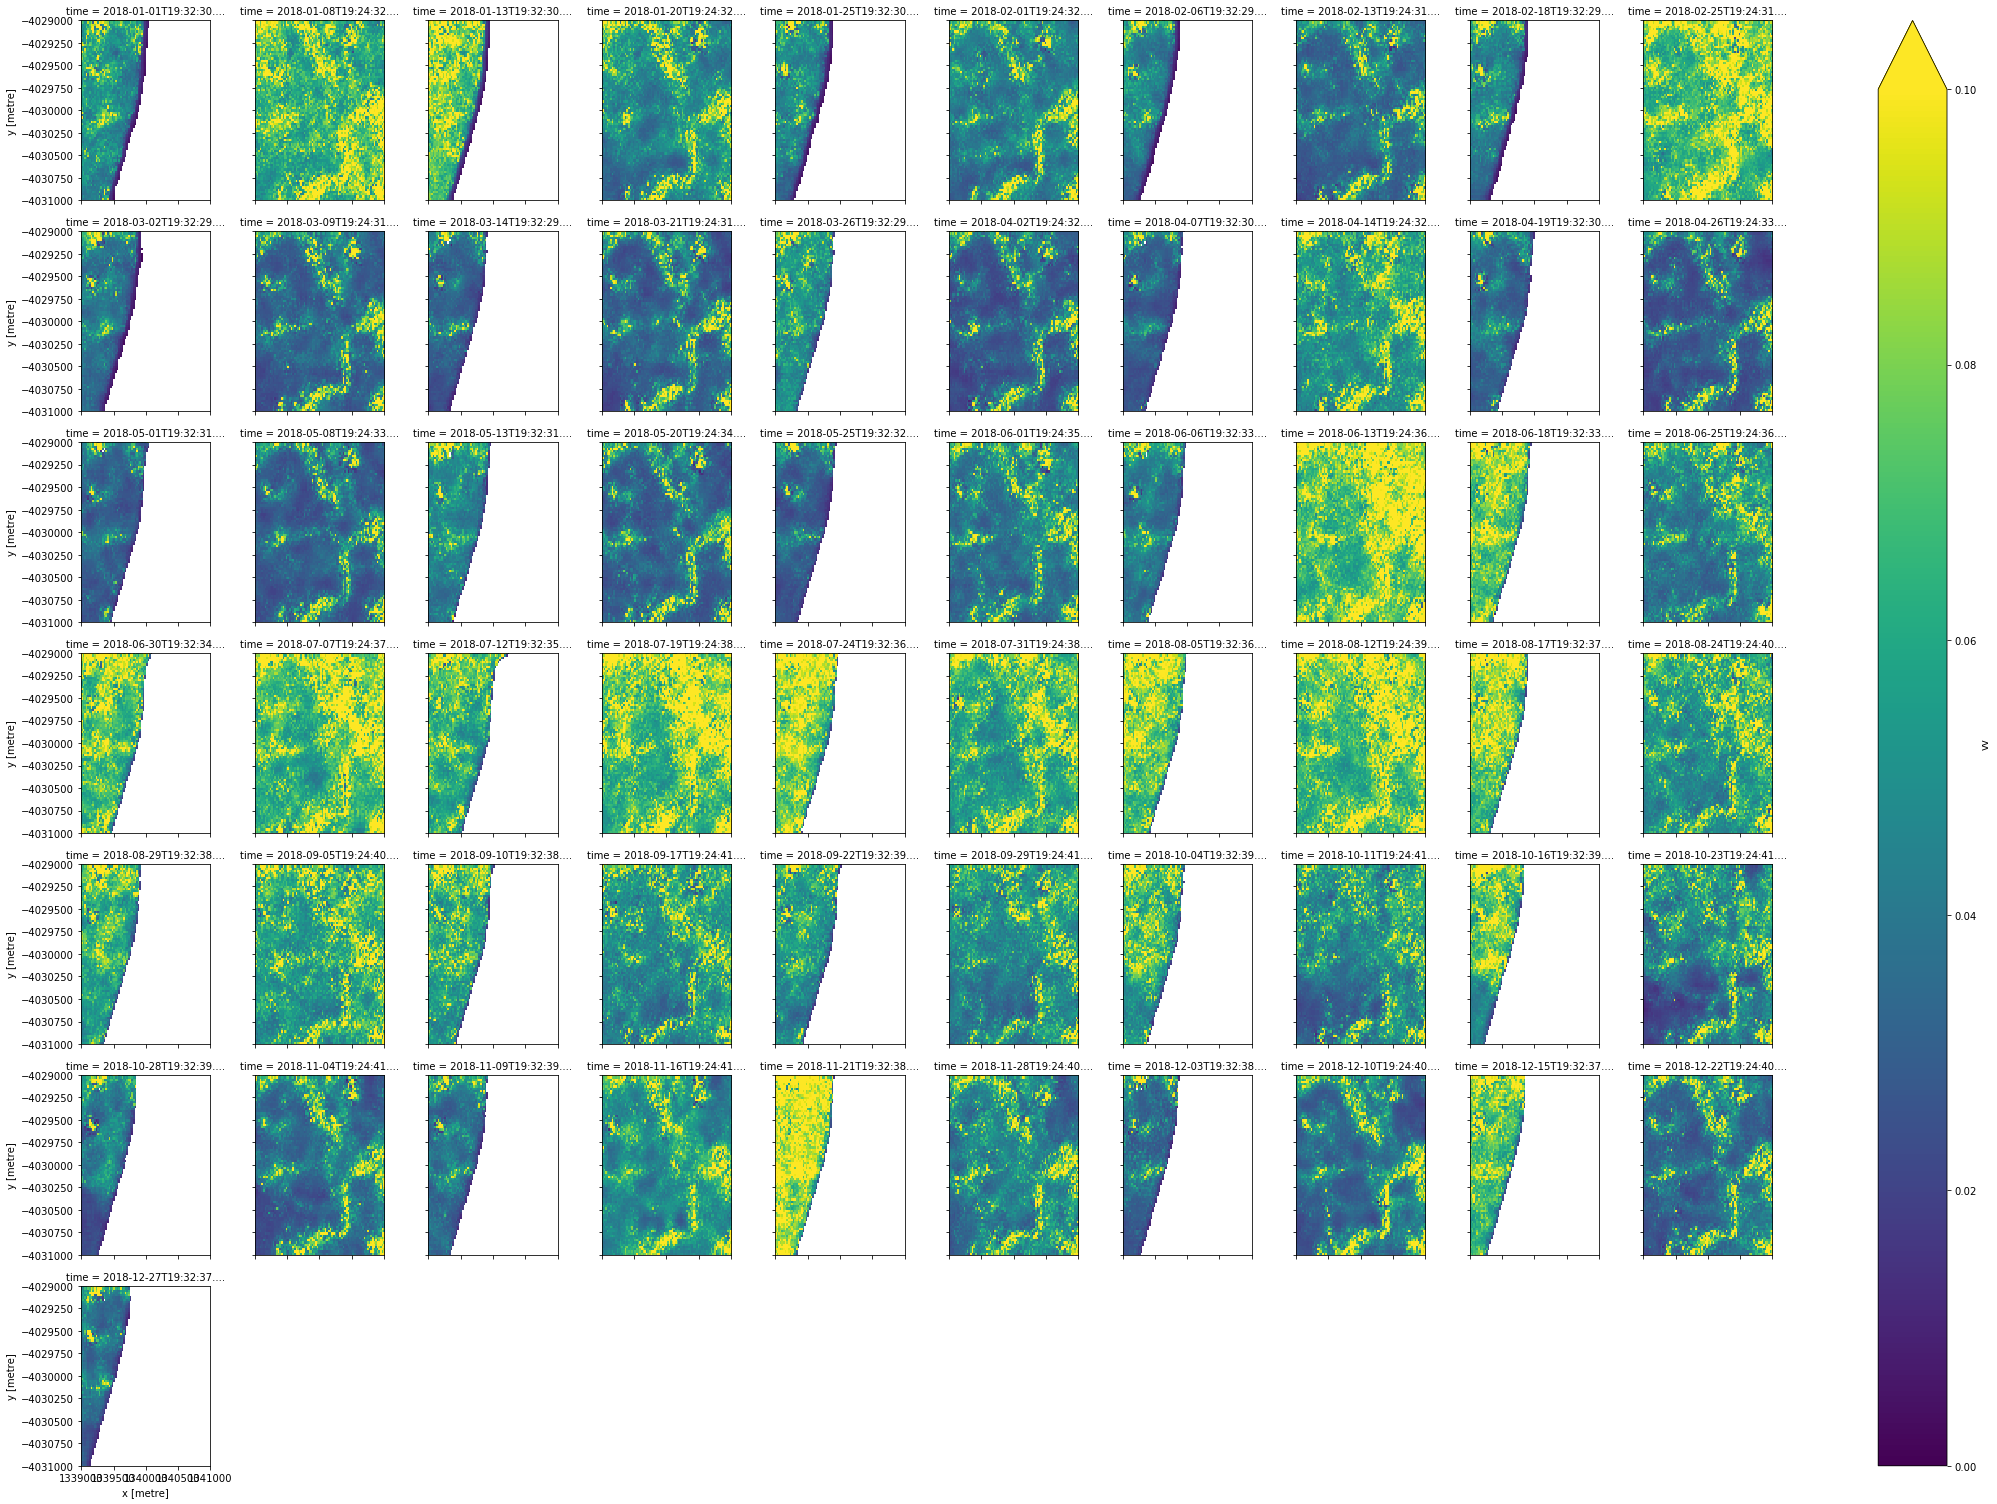

In [80]:
data.vv.plot.imshow(col='time',col_wrap=10, vmin=0, vmax=0.1);

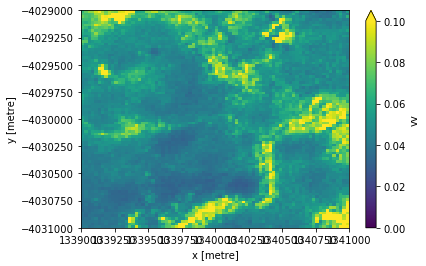

In [81]:
med = data.vv.median(axis=0)
med.plot.imshow(vmin=0, vmax=0.1);

In [73]:
ref = xr.apply_ufunc(np.nanmedian, data[bands[0]], kwargs = {'axis':-1},
                             input_core_dims=[['time']], dask='parallelized', output_dtypes=[np.float32])


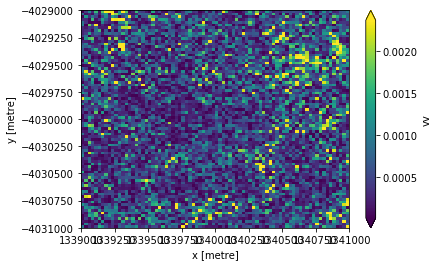

In [74]:
abs(s1_gm.vv-med).plot.imshow(robust=True);